<img src='./img/header_placeholder.png' alt='Logo EU Copernicus ECMWF' align='right' width='100%'></img>

<br>

# CAMS - Introduction to the European Air Quality Index (EAQI)

### About

This notebook provides you a practical introduction to the calculation and interpretation of the `Air Quality Index (AQI)` in Europe. Air pollution is the single largest environmental health risk in Europe, causing cardiovascular and respiratory diseases, that, in the most serious cases, lead to premature deaths.
The European Environment Agency's European Air Quality Index allows users to understand more about air quality where they live. Even though the air quality in Europe has improved over recent decades, the levels of air pollutants still exceed EU standards and the most stringent World Health Organization (WHO) guidelines.

#### How is the European Air Quality index defined?
The European Air Quality index is computed for five main pollutants regulated in the European legislation:
* `Ozone (O3)`
* `Nitrogen Dioxide (NO2)`
* `Sulphur Dioxide (SO2)`
* `Fine particulate matter with a diameter smaller than 2.5 micrometers (PM2.5)`
* `Fine particulate matter with a diameter smaller than 10 micrometers (PM10)`


The index ranges from 1 (good) to 6 (extremely poor). For each pollutant, the index is calculated separately according to the concentrations; the higher the concentrations, the higher the index (see Table below for index levels). The overall hourly European Air Quality index is simply defined as the highest value of the five individual pollutants indexes computed for the same hour. For instance, if the indices relative to O<sub>3</sub>, NO<sub>2</sub>, SO<sub>2</sub>, PM2.5 and PM10 are 1,3,1,2,2 respectively, the overall index will be 3. The overall daily European Air Quality index is the highest value of the overall hourly European Air Quality index in the corresponding day.



<img src='./img/eaqi_index_level.png' alt='European Air Quality Index' align='center' width='50%'></img>



<br>

The notebook has the following outline:

* [1 - Unzip the downloaded data files](#cams_unzip)
* [2 - Load the data with xarray](#eac4_load)
* [3 - Compute meridional mean plot of Carbon Monoxide](#meridional_mean)
* [4 - Visualize the meridional mean plot of Carbon Monoxide in August 2020](#eac4_visualize)

### Data

This notebook introduces you to the CAMS European air quality forecasts and analysis dataset. The data has the following specifications:

> **Data**: `CAMS European air quality forecasts` <br>
> **Temporal coverage**: `three-year rolling archive` <br>
> **Temporal resolution**: `hourly` <br>
> **Spatial coverage**: `Europe` <br>
> **Spatial resolution**: `0.1° x 0.1°` <br>
> **Format**: `NetCDF`<br>
> **Retrieve request**: [CDS API request](./200_atmosphere_data_store_intro.ipynb#cams_eaqi)

Get [here](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts?tab=overview) more information about the CAMS European air quality forecast dataset.

### How to access the notebook
* via [nbviewer](https://github.com/ecmwf-projects/copernicus-training/blob/master/111_c3s_climatologies_anomalies.ipynb): view a static version of the notebook 
* via [Binder](https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training/HEAD?urlpath=lab/tree/111_c3s_climatologies_anomalies.ipynb): run, execute and modify the notebook

### Further resources

* [Air pollution - European Environment Agency](https://www.eea.europa.eu/themes/air)
* [Europe's air quality status 2021](https://www.eea.europa.eu/publications/air-quality-status-2021/air-quality-status-briefing-2021)
* [Air pollution stil too high in most EU Member States](https://www.eea.europa.eu/highlights/air-pollution-still-too-high-1)


* https://www.euronews.com/weather/copernicus-air-quality-index

<hr>

### Load libraries

In [1]:
# CDS API
import cdsapi

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from matplotlib.colors import ListedColormap

from datetime import datetime

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import seaborn as sns

In [2]:
%run ./functions.ipynb

<hr>

## <a id='eaqi_load'></a>1. Load the European air quality forecast data

The Atmosphere Data Store allows you to choose between two data formats, `GRIB` and `NetCDF`. However, the data is archived in `zip` file when downloaded. For this reason, before we can load any data, we have to unzip the files. Once you downloaded the data as a zip file (see CDSAPI request [here](./200_atmosphere_data_store_intro.ipynb#eac4_monthly)), you can use the functions from the `zipfile` Python package to extract the content of a zip file. First, you construct a `ZipFile()` object and second, you apply the function `extractall()` to extract the content of the zip file.

<br>

In [3]:
eaqi_12 = xr.open_dataset('./data/cams/eaqi/202012_eaqi_europe.nc')
eaqi_12

<xarray.Dataset>
Dimensions:     (latitude: 420, level: 1, longitude: 700, time: 744)
Coordinates:
  * longitude   (longitude) float32 335.0 335.1 335.2 ... 44.75 44.85 44.95
  * latitude    (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
  * level       (level) float32 0.0
  * time        (time) timedelta64[ns] 00:00:00 01:00:00 ... 30 days 23:00:00
Data variables:
    no2_conc    (time, level, latitude, longitude) float32 ...
    o3_conc     (time, level, latitude, longitude) float32 ...
    pm10_conc   (time, level, latitude, longitude) float32 ...
    pm2p5_conc  (time, level, latitude, longitude) float32 ...
    so2_conc    (time, level, latitude, longitude) float32 ...
Attributes:
    title:        NO2/O3/PM10/PM25/SO2 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by RIUUK
    source:       Data from EURAD-IM model
    history:      Model EURAD ANALYSIS
    ANALYSIS:     Europe, 20201201-20201231+[0H_23H]
    summary:      EURAD model hourly ANALYSIS of NO2/O3/PM10/PM25/SO2 concent...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

In [4]:
timestamp = eaqi_12.time.long_name[19:27]

timestamp_init=datetime.strptime(timestamp,'%Y%m%d' )
timestamp_init

datetime.datetime(2020, 12, 1, 0, 0)

In [5]:
time_coords = pd.date_range(timestamp_init, periods=len(eaqi_12.time), freq='1h').strftime("%Y-%m-%d %H:%M:%S").astype('datetime64[ns]')
time_coords

DatetimeIndex(['2020-12-01 00:00:00', '2020-12-01 01:00:00',
               '2020-12-01 02:00:00', '2020-12-01 03:00:00',
               '2020-12-01 04:00:00', '2020-12-01 05:00:00',
               '2020-12-01 06:00:00', '2020-12-01 07:00:00',
               '2020-12-01 08:00:00', '2020-12-01 09:00:00',
               ...
               '2020-12-31 14:00:00', '2020-12-31 15:00:00',
               '2020-12-31 16:00:00', '2020-12-31 17:00:00',
               '2020-12-31 18:00:00', '2020-12-31 19:00:00',
               '2020-12-31 20:00:00', '2020-12-31 21:00:00',
               '2020-12-31 22:00:00', '2020-12-31 23:00:00'],
              dtype='datetime64[ns]', length=744, freq=None)

In [6]:
eaqi_12_assigned = eaqi_12.assign_coords(time=time_coords)
eaqi_12_assigned

<xarray.Dataset>
Dimensions:     (latitude: 420, level: 1, longitude: 700, time: 744)
Coordinates:
  * longitude   (longitude) float32 335.0 335.1 335.2 ... 44.75 44.85 44.95
  * latitude    (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
  * level       (level) float32 0.0
  * time        (time) datetime64[ns] 2020-12-01 ... 2020-12-31T23:00:00
Data variables:
    no2_conc    (time, level, latitude, longitude) float32 ...
    o3_conc     (time, level, latitude, longitude) float32 ...
    pm10_conc   (time, level, latitude, longitude) float32 ...
    pm2p5_conc  (time, level, latitude, longitude) float32 ...
    so2_conc    (time, level, latitude, longitude) float32 ...
Attributes:
    title:        NO2/O3/PM10/PM25/SO2 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by RIUUK
    source:       Data from EURAD-IM model
    history:      Model EURAD ANALYSIS
    ANALYSIS:     Europe, 20201201-20201231+[0H_23H]
    summary:      EURAD model hourly ANALYSIS of NO2/O3/PM10/PM25/SO2 concent...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

In [7]:
eaqi_12_assigned = eaqi_12_assigned.assign_coords(longitude=(((eaqi_12_assigned.longitude + 180) % 360) - 180)).sortby('longitude')
eaqi_12_assigned

<xarray.Dataset>
Dimensions:     (latitude: 420, level: 1, longitude: 700, time: 744)
Coordinates:
  * longitude   (longitude) float32 -24.95 -24.85 -24.75 ... 44.75 44.85 44.95
  * latitude    (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
  * level       (level) float32 0.0
  * time        (time) datetime64[ns] 2020-12-01 ... 2020-12-31T23:00:00
Data variables:
    no2_conc    (time, level, latitude, longitude) float32 ...
    o3_conc     (time, level, latitude, longitude) float32 ...
    pm10_conc   (time, level, latitude, longitude) float32 ...
    pm2p5_conc  (time, level, latitude, longitude) float32 ...
    so2_conc    (time, level, latitude, longitude) float32 ...
Attributes:
    title:        NO2/O3/PM10/PM25/SO2 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by RIUUK
    source:       Data from EURAD-IM model
    history:      Model EURAD ANALYSIS
    ANALYSIS:     Europe, 20201201-20201231+[0H_23H]
    summary:      EURAD model hourly ANALYSIS of NO2/O3/PM10/PM25/SO2 concent...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

In [8]:
eaqi_12_assigned = eaqi_12_assigned.squeeze(drop=True)

eaqi_12_assigned

<xarray.Dataset>
Dimensions:     (latitude: 420, longitude: 700, time: 744)
Coordinates:
  * longitude   (longitude) float32 -24.95 -24.85 -24.75 ... 44.75 44.85 44.95
  * latitude    (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
  * time        (time) datetime64[ns] 2020-12-01 ... 2020-12-31T23:00:00
Data variables:
    no2_conc    (time, latitude, longitude) float32 ...
    o3_conc     (time, latitude, longitude) float32 ...
    pm10_conc   (time, latitude, longitude) float32 ...
    pm2p5_conc  (time, latitude, longitude) float32 ...
    so2_conc    (time, latitude, longitude) float32 ...
Attributes:
    title:        NO2/O3/PM10/PM25/SO2 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by RIUUK
    source:       Data from EURAD-IM model
    history:      Model EURAD ANALYSIS
    ANALYSIS:     Europe, 20201201-20201231+[0H_23H]
    summary:      EURAD model hourly ANALYSIS of NO2/O3/PM10/PM25/SO2 concent...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

In [ ]:
ozone_limits = [0, 50, 100, 130, 240, 380, 800]
no2_limits = [0, 40, 90, 120, 230, 340, 1000]
so2_limits = [0, 100, 200, 350, 500, 750, 1250]
pm25_limits = [0, 20, 40, 50, 100, 150, 1200]
pm10_limits = [0, 10, 20, 25, 50, 75, 800]




<br>

In [236]:
eur_cities = {'london_lat': 51.5,
              'london_lon': -0.12,
              'paris_lat': 48.9,
              'paris_lon': 2.3,
              'rome_lat': 41.9,
              'rome_lon': 12.5
}

In [11]:
eaqi_12_ts = eaqi_12_assigned.sel(latitude=eur_cities['london_lat'], longitude=eur_cities['london_lon'], method='nearest')
eaqi_12_ts

<xarray.Dataset>
Dimensions:     (time: 744)
Coordinates:
    longitude   float32 -0.15
    latitude    float32 51.55
  * time        (time) datetime64[ns] 2020-12-01 ... 2020-12-31T23:00:00
Data variables:
    no2_conc    (time) float32 ...
    o3_conc     (time) float32 ...
    pm10_conc   (time) float32 ...
    pm2p5_conc  (time) float32 ...
    so2_conc    (time) float32 ...
Attributes:
    title:        NO2/O3/PM10/PM25/SO2 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by RIUUK
    source:       Data from EURAD-IM model
    history:      Model EURAD ANALYSIS
    ANALYSIS:     Europe, 20201201-20201231+[0H_23H]
    summary:      EURAD model hourly ANALYSIS of NO2/O3/PM10/PM25/SO2 concent...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

In [12]:
eaqi_12_ts_daily = eaqi_12_ts.resample(time='1D').max()
eaqi_12_ts_daily

<xarray.Dataset>
Dimensions:     (time: 31)
Coordinates:
  * time        (time) datetime64[ns] 2020-12-01 2020-12-02 ... 2020-12-31
    longitude   float32 -0.15
    latitude    float32 51.55
Data variables:
    no2_conc    (time) float64 44.45 58.73 67.38 70.81 ... 64.5 80.92 49.75
    o3_conc     (time) float64 51.8 32.69 53.45 77.86 ... 34.54 30.79 32.84
    pm10_conc   (time) float64 22.45 51.24 30.27 16.56 ... 43.1 33.88 32.84
    pm2p5_conc  (time) float64 20.77 48.16 27.83 15.03 ... 39.85 30.21 29.11
    so2_conc    (time) float64 8.376 37.58 55.96 17.39 ... 24.89 32.63 13.26

In [78]:
eaqi_ts_daily_df = eaqi_12_ts_daily.to_dataframe()
eaqi_ts_daily_df

,longitude,latitude,no2_conc,o3_conc,pm10_conc,pm2p5_conc,so2_conc
time,,,,,,,
2020-12-01,-0.150024,51.549999,44.449394,51.801792,22.448458,20.769114,8.376390
2020-12-02,-0.150024,51.549999,58.728992,32.693123,51.238750,48.157619,37.582596
2020-12-03,-0.150024,51.549999,67.380257,53.449184,30.272989,27.828772,55.957230
2020-12-04,-0.150024,51.549999,70.812126,77.863487,16.556995,15.026991,17.386185
2020-12-05,-0.150024,51.549999,39.210476,54.060181,19.313433,17.912811,11.885561
2020-12-06,-0.150024,51.549999,34.573757,39.689949,25.534267,22.463884,8.398274
2020-12-07,-0.150024,51.549999,57.804245,26.063162,40.667145,38.524876,19.458866
2020-12-08,-0.150024,51.549999,55.206940,13.286389,41.603371,39.574974,22.642780
2020-12-09,-0.150024,51.549999,55.092064,34.879898,31.466757,28.805996,31.855165


In [81]:
ozone_limits = [0, 50, 100, 130, 240, 380, 800]
no2_limits = [0, 40, 90, 120, 230, 340, 1000]
so2_limits = [0, 100, 200, 350, 500, 750, 1250]
pm25_limits = [0, 20, 40, 50, 100, 150, 1200]
pm10_limits = [0, 10, 20, 25, 50, 75, 800]

buckets_name = [1, 2, 3, 4, 5, 6]

ozone = pd.Series(pd.cut(eaqi_ts_daily_df['o3_conc'], ozone_limits , labels = buckets_name))
no2 = pd.Series(pd.cut(eaqi_ts_daily_df['no2_conc'], no2_limits , labels = buckets_name))
so2 = pd.Series(pd.cut(eaqi_ts_daily_df['so2_conc'], so2_limits , labels = buckets_name))
pm25 = pd.Series(pd.cut(eaqi_ts_daily_df['pm2p5_conc'], pm25_limits , labels = buckets_name))
pm10 = pd.Series(pd.cut(eaqi_ts_daily_df['pm10_conc'], pm10_limits , labels = buckets_name))

In [87]:
df = pd.DataFrame(dict(index = eaqi_ts_daily_df.index, o3 = ozone, no2 = no2, so2 = so2, pm25=pm25, pm10=pm10)).set_index('index')
df


,o3,no2,so2,pm25,pm10
index,,,,,
2020-12-01,2,2,1,2,3
2020-12-02,1,2,1,3,5
2020-12-03,2,2,1,2,4
2020-12-04,2,2,1,1,2
2020-12-05,2,1,1,1,2
2020-12-06,1,1,1,2,4
2020-12-07,1,2,1,2,4
2020-12-08,1,2,1,2,4
2020-12-09,1,2,1,2,4


In [93]:
df['level'] = df.max(axis=1).astype(int)
df

,o3,no2,so2,pm25,pm10,level
index,,,,,,
2020-12-01,2,2,1,2,3,3
2020-12-02,1,2,1,3,5,5
2020-12-03,2,2,1,2,4,4
2020-12-04,2,2,1,1,2,2
2020-12-05,2,1,1,1,2,2
2020-12-06,1,1,1,2,4,4
2020-12-07,1,2,1,2,4,4
2020-12-08,1,2,1,2,4,4
2020-12-09,1,2,1,2,4,4


In [108]:
df = (df.T).iloc[::-1]
df

index,2020-12-01,2020-12-02,2020-12-03,2020-12-04,2020-12-05,2020-12-06,2020-12-07,2020-12-08,2020-12-09,2020-12-10,...,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31
level,3,5,4,2,2,4,4,4,4,3,...,4,2,2,3,2,2,4,4,4,4
pm10,3,5,4,2,2,4,4,4,4,3,...,4,2,1,3,2,2,4,4,4,4
pm25,2,3,2,1,1,2,2,2,2,1,...,2,1,1,1,1,1,2,2,2,2
so2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
no2,2,2,2,2,1,1,2,2,2,1,...,2,2,1,2,1,2,2,2,2,2
o3,2,1,2,2,2,1,1,1,1,1,...,2,2,2,2,2,2,2,1,1,1


In [115]:
df[df<0] = np.nan
df

index,2020-12-01,2020-12-02,2020-12-03,2020-12-04,2020-12-05,2020-12-06,2020-12-07,2020-12-08,2020-12-09,2020-12-10,...,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31
level,3,5,4,2,2,4,4,4,4,3,...,4,2,2,3,2,2,4,4,4,4
pm10,3,5,4,2,2,4,4,4,4,3,...,4,2,1,3,2,2,4,4,4,4
pm25,2,3,2,1,1,2,2,2,2,1,...,2,1,1,1,1,1,2,2,2,2
so2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
no2,2,2,2,2,1,1,2,2,2,1,...,2,2,1,2,1,2,2,2,2,2
o3,2,1,2,2,2,1,1,1,1,1,...,2,2,2,2,2,2,2,1,1,1


In [40]:
cmap = ListedColormap(['#5AAA5F', '#A7D25C', '#ECD347', '#F5BE41', '#F09235', '#D93322'])
cmap

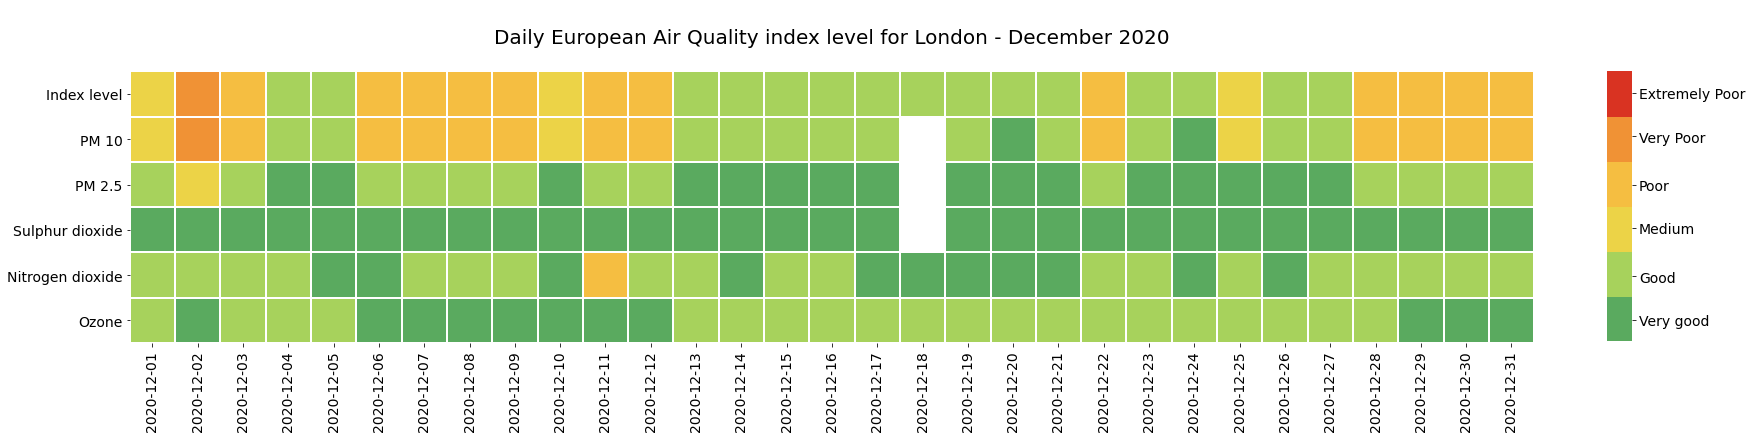

In [237]:

fig, ax = plt.subplots(1,1,figsize=(35,5))

cbar_ax = fig.add_axes([.82, .13, .01, .75])

g = sns.heatmap(df, cmap=cmap, linewidth=1, linecolor='w', square=True, cbar_ax = cbar_ax,vmin=1, vmax=6, ax=ax)



g.set_title("\nDaily European Air Quality index level for London - December 2020\n", fontsize=20)
g.set(xlabel=None)

ylabels=['Index level', 'PM 10', 'PM 2.5', 'Sulphur dioxide', 'Nitrogen dioxide', 'Ozone']
g.set_yticklabels(ylabels,fontsize=14, rotation=0)

xlabels=df.columns.format('%Y-%m-%d')[1::]
g.set_xticklabels(xlabels, fontsize=14)

cbar = ax.collections[0].colorbar
cbar.set_ticks([1.4,2.2,3.1,3.9,4.8,5.6])
cbar.set_ticklabels(['Very good', 'Good', 'Medium', 'Poor', 'Very Poor', 'Extremely Poor'])
cbar.ax.tick_params(labelsize=14)


<br>

In [238]:
eaqi_12_ts = eaqi_12_assigned.sel(latitude=eur_cities['paris_lat'], longitude=eur_cities['paris_lon'], method='nearest')
eaqi_12_ts

<xarray.Dataset>
Dimensions:     (time: 744)
Coordinates:
    longitude   float32 2.25
    latitude    float32 48.95
  * time        (time) datetime64[ns] 2020-12-01 ... 2020-12-31T23:00:00
Data variables:
    no2_conc    (time) float32 ...
    o3_conc     (time) float32 ...
    pm10_conc   (time) float32 ...
    pm2p5_conc  (time) float32 ...
    so2_conc    (time) float32 ...
Attributes:
    title:        NO2/O3/PM10/PM25/SO2 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by RIUUK
    source:       Data from EURAD-IM model
    history:      Model EURAD ANALYSIS
    ANALYSIS:     Europe, 20201201-20201231+[0H_23H]
    summary:      EURAD model hourly ANALYSIS of NO2/O3/PM10/PM25/SO2 concent...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

In [239]:
eaqi_12_ts_daily = eaqi_12_ts.resample(time='1D').max()
eaqi_12_ts_daily

<xarray.Dataset>
Dimensions:     (time: 31)
Coordinates:
  * time        (time) datetime64[ns] 2020-12-01 2020-12-02 ... 2020-12-31
    longitude   float32 2.25
    latitude    float32 48.95
Data variables:
    no2_conc    (time) float64 41.72 52.03 31.89 37.56 ... 49.19 46.13 52.14
    o3_conc     (time) float64 58.34 57.21 59.14 76.01 ... 60.87 64.69 63.19
    pm10_conc   (time) float64 14.9 36.33 27.37 13.83 ... 27.46 28.77 27.88
    pm2p5_conc  (time) float64 11.59 34.97 26.66 11.91 ... 25.4 24.04 24.72
    so2_conc    (time) float64 3.369 18.32 6.777 10.71 ... 8.212 6.094 5.92

In [240]:
eaqi_ts_daily_df = eaqi_12_ts_daily.to_dataframe()
eaqi_ts_daily_df

,longitude,latitude,no2_conc,o3_conc,pm10_conc,pm2p5_conc,so2_conc
time,,,,,,,
2020-12-01,2.25,48.950001,41.719147,58.339241,14.901156,11.594663,3.369280
2020-12-02,2.25,48.950001,52.031853,57.205498,36.326313,34.968761,18.319952
2020-12-03,2.25,48.950001,31.887268,59.140091,27.366760,26.655983,6.777498
2020-12-04,2.25,48.950001,37.563354,76.007988,13.832015,11.912621,10.705093
2020-12-05,2.25,48.950001,28.884373,63.233612,11.945106,11.485285,4.061918
2020-12-06,2.25,48.950001,40.588760,37.283089,26.263357,21.952242,9.742848
2020-12-07,2.25,48.950001,51.916092,20.995571,40.843822,32.807281,12.738099
2020-12-08,2.25,48.950001,45.099236,19.491295,27.919689,23.738989,6.058486
2020-12-09,2.25,48.950001,57.387665,26.507849,31.423473,27.048170,13.245938


In [241]:
ozone_limits = [0, 50, 100, 130, 240, 380, 800]
no2_limits = [0, 40, 90, 120, 230, 340, 1000]
so2_limits = [0, 100, 200, 350, 500, 750, 1250]
pm25_limits = [0, 20, 40, 50, 100, 150, 1200]
pm10_limits = [0, 10, 20, 25, 50, 75, 800]

buckets_name = [1, 2, 3, 4, 5, 6]

ozone = pd.Series(pd.cut(eaqi_ts_daily_df['o3_conc'], ozone_limits , labels = buckets_name))
no2 = pd.Series(pd.cut(eaqi_ts_daily_df['no2_conc'], no2_limits , labels = buckets_name))
so2 = pd.Series(pd.cut(eaqi_ts_daily_df['so2_conc'], so2_limits , labels = buckets_name))
pm25 = pd.Series(pd.cut(eaqi_ts_daily_df['pm2p5_conc'], pm25_limits , labels = buckets_name))
pm10 = pd.Series(pd.cut(eaqi_ts_daily_df['pm10_conc'], pm10_limits , labels = buckets_name))

In [242]:
df = pd.DataFrame(dict(index = eaqi_ts_daily_df.index, o3 = ozone, no2 = no2, so2 = so2, pm25=pm25, pm10=pm10)).set_index('index')
df


,o3,no2,so2,pm25,pm10
index,,,,,
2020-12-01,2,2,1,1,2
2020-12-02,2,2,1,2,4
2020-12-03,2,1,1,2,4
2020-12-04,2,1,1,1,2
2020-12-05,2,1,1,1,2
2020-12-06,1,2,1,2,4
2020-12-07,1,2,1,2,4
2020-12-08,1,2,1,2,4
2020-12-09,1,2,1,2,4


In [243]:
df['level'] = df.max(axis=1).astype(int)
df

,o3,no2,so2,pm25,pm10,level
index,,,,,,
2020-12-01,2,2,1,1,2,2
2020-12-02,2,2,1,2,4,4
2020-12-03,2,1,1,2,4,4
2020-12-04,2,1,1,1,2,2
2020-12-05,2,1,1,1,2,2
2020-12-06,1,2,1,2,4,4
2020-12-07,1,2,1,2,4,4
2020-12-08,1,2,1,2,4,4
2020-12-09,1,2,1,2,4,4


In [244]:
df = (df.T).iloc[::-1]
df

index,2020-12-01,2020-12-02,2020-12-03,2020-12-04,2020-12-05,2020-12-06,2020-12-07,2020-12-08,2020-12-09,2020-12-10,...,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31
level,2,4,4,2,2,4,4,4,4,3,...,2,2,2,2,3,2,2,4,4,4
pm10,2,4,4,2,2,4,4,4,4,3,...,1,2,1,2,3,1,1,4,4,4
pm25,1,2,2,1,1,2,2,2,2,2,...,1,1,1,1,2,1,1,2,2,2
so2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
no2,2,2,1,1,1,2,2,2,2,2,...,1,1,1,1,1,1,2,2,2,2
o3,2,2,2,2,2,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2


In [245]:
df[df<0] = np.nan
df

index,2020-12-01,2020-12-02,2020-12-03,2020-12-04,2020-12-05,2020-12-06,2020-12-07,2020-12-08,2020-12-09,2020-12-10,...,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31
level,2,4,4,2,2,4,4,4,4,3,...,2,2,2,2,3,2,2,4,4,4
pm10,2,4,4,2,2,4,4,4,4,3,...,1,2,1,2,3,1,1,4,4,4
pm25,1,2,2,1,1,2,2,2,2,2,...,1,1,1,1,2,1,1,2,2,2
so2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
no2,2,2,1,1,1,2,2,2,2,2,...,1,1,1,1,1,1,2,2,2,2
o3,2,2,2,2,2,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2


In [246]:
cmap = ListedColormap(['#5AAA5F', '#A7D25C', '#ECD347', '#F5BE41', '#F09235', '#D93322'])
cmap

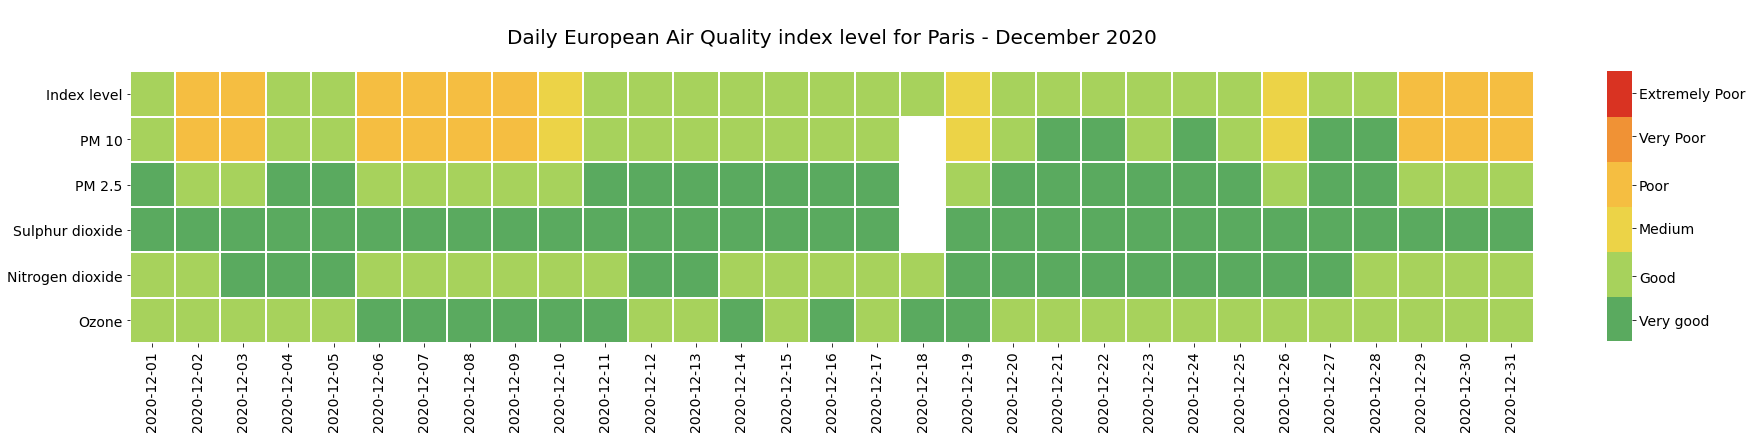

In [247]:

fig, ax = plt.subplots(1,1,figsize=(35,5))

cbar_ax = fig.add_axes([.82, .13, .01, .75])

g = sns.heatmap(df, cmap=cmap, linewidth=1, linecolor='w', square=True, cbar_ax = cbar_ax,vmin=1, vmax=6, ax=ax)



g.set_title("\nDaily European Air Quality index level for Paris - December 2020\n", fontsize=20)
g.set(xlabel=None)

ylabels=['Index level', 'PM 10', 'PM 2.5', 'Sulphur dioxide', 'Nitrogen dioxide', 'Ozone']
g.set_yticklabels(ylabels,fontsize=14, rotation=0)

xlabels=df.columns.format('%Y-%m-%d')[1::]
g.set_xticklabels(xlabels, fontsize=14)

cbar = ax.collections[0].colorbar
cbar.set_ticks([1.4,2.2,3.1,3.9,4.8,5.6])
cbar.set_ticklabels(['Very good', 'Good', 'Medium', 'Poor', 'Very Poor', 'Extremely Poor'])
cbar.ax.tick_params(labelsize=14)


<br>

In [248]:
eaqi_12_ts = eaqi_12_assigned.sel(latitude=eur_cities['rome_lat'], longitude=eur_cities['rome_lon'], method='nearest')
eaqi_12_ts

<xarray.Dataset>
Dimensions:     (time: 744)
Coordinates:
    longitude   float32 12.55
    latitude    float32 41.95
  * time        (time) datetime64[ns] 2020-12-01 ... 2020-12-31T23:00:00
Data variables:
    no2_conc    (time) float32 ...
    o3_conc     (time) float32 ...
    pm10_conc   (time) float32 ...
    pm2p5_conc  (time) float32 ...
    so2_conc    (time) float32 ...
Attributes:
    title:        NO2/O3/PM10/PM25/SO2 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by RIUUK
    source:       Data from EURAD-IM model
    history:      Model EURAD ANALYSIS
    ANALYSIS:     Europe, 20201201-20201231+[0H_23H]
    summary:      EURAD model hourly ANALYSIS of NO2/O3/PM10/PM25/SO2 concent...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

In [249]:
eaqi_12_ts_daily = eaqi_12_ts.resample(time='1D').max()
eaqi_12_ts_daily

<xarray.Dataset>
Dimensions:     (time: 31)
Coordinates:
  * time        (time) datetime64[ns] 2020-12-01 2020-12-02 ... 2020-12-31
    longitude   float32 12.55
    latitude    float32 41.95
Data variables:
    no2_conc    (time) float64 32.21 35.82 51.82 33.24 ... 30.4 40.14 72.39
    o3_conc     (time) float64 65.76 69.61 75.86 67.67 ... 105.1 94.95 90.12
    pm10_conc   (time) float64 16.04 10.88 14.55 12.26 ... 10.54 11.18 30.61
    pm2p5_conc  (time) float64 15.34 10.72 14.0 11.88 ... 8.441 10.34 29.48
    so2_conc    (time) float64 2.521 2.235 2.831 2.295 ... 1.637 2.465 4.443

In [250]:
eaqi_ts_daily_df = eaqi_12_ts_daily.to_dataframe()
eaqi_ts_daily_df

,longitude,latitude,no2_conc,o3_conc,pm10_conc,pm2p5_conc,so2_conc
time,,,,,,,
2020-12-01,12.550003,41.950001,32.209675,65.759460,16.035542,15.335595,2.521006
2020-12-02,12.550003,41.950001,35.823730,69.609314,10.875725,10.722329,2.234799
2020-12-03,12.550003,41.950001,51.820621,75.860802,14.547868,14.004692,2.831143
2020-12-04,12.550003,41.950001,33.243126,67.671349,12.261233,11.876157,2.295167
2020-12-05,12.550003,41.950001,7.734485,67.656570,7.995117,6.754665,4.375977
2020-12-06,12.550003,41.950001,47.821800,110.246544,17.000307,16.046888,3.125934
2020-12-07,12.550003,41.950001,35.385822,101.827705,10.460719,9.705311,1.765557
2020-12-08,12.550003,41.950001,36.251747,69.201439,10.051530,9.362177,2.932438
2020-12-09,12.550003,41.950001,39.399750,69.469963,13.907120,12.897236,3.789183


In [251]:
ozone_limits = [0, 50, 100, 130, 240, 380, 800]
no2_limits = [0, 40, 90, 120, 230, 340, 1000]
so2_limits = [0, 100, 200, 350, 500, 750, 1250]
pm25_limits = [0, 20, 40, 50, 100, 150, 1200]
pm10_limits = [0, 10, 20, 25, 50, 75, 800]

buckets_name = [1, 2, 3, 4, 5, 6]

ozone = pd.Series(pd.cut(eaqi_ts_daily_df['o3_conc'], ozone_limits , labels = buckets_name))
no2 = pd.Series(pd.cut(eaqi_ts_daily_df['no2_conc'], no2_limits , labels = buckets_name))
so2 = pd.Series(pd.cut(eaqi_ts_daily_df['so2_conc'], so2_limits , labels = buckets_name))
pm25 = pd.Series(pd.cut(eaqi_ts_daily_df['pm2p5_conc'], pm25_limits , labels = buckets_name))
pm10 = pd.Series(pd.cut(eaqi_ts_daily_df['pm10_conc'], pm10_limits , labels = buckets_name))

In [252]:
df = pd.DataFrame(dict(index = eaqi_ts_daily_df.index, o3 = ozone, no2 = no2, so2 = so2, pm25=pm25, pm10=pm10)).set_index('index')
df


,o3,no2,so2,pm25,pm10
index,,,,,
2020-12-01,2,1,1,1,2
2020-12-02,2,1,1,1,2
2020-12-03,2,2,1,1,2
2020-12-04,2,1,1,1,2
2020-12-05,2,1,1,1,1
2020-12-06,3,2,1,1,2
2020-12-07,3,1,1,1,2
2020-12-08,2,1,1,1,2
2020-12-09,2,1,1,1,2


In [253]:
df['level'] = df.max(axis=1).astype(int)
df

,o3,no2,so2,pm25,pm10,level
index,,,,,,
2020-12-01,2,1,1,1,2,2
2020-12-02,2,1,1,1,2,2
2020-12-03,2,2,1,1,2,2
2020-12-04,2,1,1,1,2,2
2020-12-05,2,1,1,1,1,2
2020-12-06,3,2,1,1,2,3
2020-12-07,3,1,1,1,2,3
2020-12-08,2,1,1,1,2,2
2020-12-09,2,1,1,1,2,2


In [254]:
df = (df.T).iloc[::-1]
df

index,2020-12-01,2020-12-02,2020-12-03,2020-12-04,2020-12-05,2020-12-06,2020-12-07,2020-12-08,2020-12-09,2020-12-10,...,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31
level,2,2,2,2,2,3,3,2,2,3,...,4,4,2,2,3,3,2,3,2,4
pm10,2,2,2,2,1,2,2,2,2,3,...,4,4,2,1,2,3,2,2,2,4
pm25,1,1,1,1,1,1,1,1,1,2,...,2,2,1,1,1,2,1,1,1,2
so2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
no2,1,1,2,1,1,2,1,1,1,2,...,2,2,1,1,1,1,1,1,2,2
o3,2,2,2,2,2,3,3,2,2,2,...,1,2,2,2,3,2,2,3,2,2


In [255]:
df[df<0] = np.nan
df

index,2020-12-01,2020-12-02,2020-12-03,2020-12-04,2020-12-05,2020-12-06,2020-12-07,2020-12-08,2020-12-09,2020-12-10,...,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31
level,2,2,2,2,2,3,3,2,2,3,...,4,4,2,2,3,3,2,3,2,4
pm10,2,2,2,2,1,2,2,2,2,3,...,4,4,2,1,2,3,2,2,2,4
pm25,1,1,1,1,1,1,1,1,1,2,...,2,2,1,1,1,2,1,1,1,2
so2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
no2,1,1,2,1,1,2,1,1,1,2,...,2,2,1,1,1,1,1,1,2,2
o3,2,2,2,2,2,3,3,2,2,2,...,1,2,2,2,3,2,2,3,2,2


In [256]:
cmap = ListedColormap(['#5AAA5F', '#A7D25C', '#ECD347', '#F5BE41', '#F09235', '#D93322'])
cmap

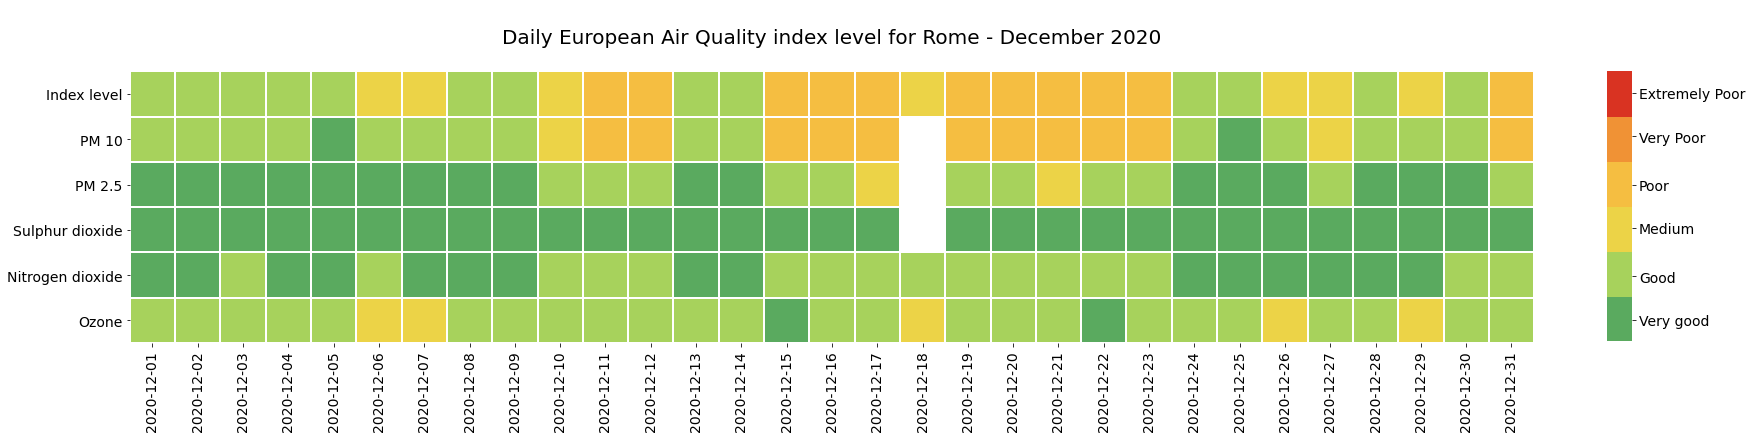

In [257]:

fig, ax = plt.subplots(1,1,figsize=(35,5))

cbar_ax = fig.add_axes([.82, .13, .01, .75])

g = sns.heatmap(df, cmap=cmap, linewidth=1, linecolor='w', square=True, cbar_ax = cbar_ax,vmin=1, vmax=6, ax=ax)



g.set_title("\nDaily European Air Quality index level for Rome - December 2020\n", fontsize=20)
g.set(xlabel=None)

ylabels=['Index level', 'PM 10', 'PM 2.5', 'Sulphur dioxide', 'Nitrogen dioxide', 'Ozone']
g.set_yticklabels(ylabels,fontsize=14, rotation=0)

xlabels=df.columns.format('%Y-%m-%d')[1::]
g.set_xticklabels(xlabels, fontsize=14)

cbar = ax.collections[0].colorbar
cbar.set_ticks([1.4,2.2,3.1,3.9,4.8,5.6])
cbar.set_ticklabels(['Very good', 'Good', 'Medium', 'Poor', 'Very Poor', 'Extremely Poor'])
cbar.ax.tick_params(labelsize=14)


<hr>

<p><img src='./img/copernicus_logo.png' align='right' alt='Logo EU Copernicus' width='20%'></img></p>
<br><br><br><br><br>
<span style='float:right'><p style=\"text-align:right;\">This project is licensed under <a href="./LICENSE">APACHE License 2.0</a>. | <a href=\"https://github.com/ecmwf-projects/copernicus-training">View on GitHub</a></span>